# Lab 4.2: Random Forests

Following on from Lab 4.1: Decision trees, Random forests can be also used for either regression or classification tasks. To overcome Decisions Trees tendancy to overfit, one can aggregate the results from many decision trees with an [ensemble approach](http://scikit-learn.org/stable/modules/ensemble.html). 

In this lesson we will focus on Random Forests, which uses bagging to prevent overfitting by only allowing a given decision tree to optimize for a random subset of the data for every tree, and a random subset of the input features at every split.

Here's a look ahead at what we'll be doing in this notebook:

1. [Import packages](#packages)
2. [Load data](#loaddata)
3. [Bagging](#bagging)
4. [Build a Random Forest](#randomforest)
5. [Tune parameters](#parameters)
6. [Feature Importance](#featureimportance)
7. [Homework](#homework)


A quick refresher on Bagging:
- Grow multiple decisions trees from random subsets of the data
- All features are considered at every split in the decision tree
- The result is the average prediction of all trees

A quick refresher on the Random Forest theory:
- Random Forest is based on Decision Trees -> many trees = a forest!
- Grows multiple trees on random subsets of the parent dataset
- **At every split, a new random subset of features is chosen**
- This leads to "decorrelated" trees which leads to a large increase in performance!

Again, we will be looking at how we can predict the loan amount using the random forest algorithm. However, it is worth mentioning that this methods can also be used to classify data, for example some interesting classification questions we could investigate are:
- Can we classify which loans expired and which one got funded?
- Is a loan posted by a male or female?

Feel free to investigate these on your own time! Here is a very [simple example](https://bicorner.com/2015/10/26/random-forest-using-ipython/) of how the RandomForestClassifier works: 

## 1. Import packages
<a id='loaddata'></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from ggplot import *
plt.style.use('ggplot')
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

/home/rosina/anaconda2/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/rosina/anaconda2/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/rosina/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 2. Load and format data
<a id='loaddata'></a>

In [2]:
# Load data to pandas DataFrame
data_path = '../data/'
df = pd.read_csv(data_path+'df_end_of_linear.csv', low_memory=False)

In [3]:
# TODO: Remove this part and incorporate it into feature engineering section.
# potentially the feature engineering section should show how to do one hot encoding and this module
# will reference one hot encoding and remove any cols that are strings to highligh that sklearn's implementation
# cannot handle strings.
df = df.dropna()
cols = df[['loan_amount', 
           'partner_delinquency_rate',
            'posted_year',
           'posted_month',
           'female',
           'num_tags',
           'parent',
           'tag_#Woman Owned Biz',
           'age_int',
           'tag_#Repeat Borrower',
           'children_int',
          'more_one_partner_country',
          'terms.repayment_term',
           'tag_#Schooling',
           'married',
           'pct_female',
           'exploratory_partner',
           'partner_dollar_amount',
           'top_partner_id',
           'num_partner_countries',
           'days_to_fund',
            'hours_to_fund',
            'bc_partner_others',
           'bc_partner_HIHEA',
           'bc_partner_OAF_high',
           'bc_partner_OAF_low',
         'sector_Personal Use',
           'sector_Health',
           'sector_Wholesale',
           'sector_Agriculture',
           'kids']]


In [4]:
y = df['loan_amount']
# drop returns a copy of the DataFrame with the specified columns removed.  
X = cols.drop('loan_amount', axis=1)

In [5]:
# Split data into training and testing sets;
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3. Bagging
<a id='bagging'></a>

Decision Trees alone naturally overfit to the data. Better perforamnce is generally achieved when an **ensemble approach** such as bagging is used.

To start with Bagging is a shorter term for Bootstrapping Aggregation which is a general procedure to reduce variance in model that have a tendancy to overfit. Again, here is a [great blog](https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/) going into more detail if you need to refresh your memory. This diagram below is taken from the website to give a visual overview of how bagging work in the context of a classifying algorithm.

<img src="../images/bagging.png" alt = 'bagging' style="width: 500px;height=500"/>

As an ensemble method, bagging does the following:
- Creates N random subsamples of the dataset using selection with replacement. (Statistically 1/3 of the data is left of each subsample)
- Trains a new decision tree on each N subsample
- Takes the prediction from each and every N tree and averages the result
- This average is the final output of the bagging model. 
This is an **Ensemble approach** where we use the results of several random analyses to find an average response.

Furthermore, for each tree, there will be a sample of data which was not used to train the algorithm. This means that we can also measure the **out-of-bag** score ( or oob_score). This score evaluates the performance of the model on the sample not used while training an individual tree. (Remember a random ~1/3 of data are not used to train a given tree).


## 4. Build a Random Forest
<a id='randomforest'></a>

Even with bagging, the decision trees can be largely correlated, meaning that the trees are probably going to split on the same features and result in very similar predictions for each subset.

To de-correlate the trees, we can use a Random Forest Regressor, which at each split, only considers a random subsample of the features! This means that the trees are forced to make different split decisions. 

**A Random Forest is essentially bagged decision trees where each decision tree only considers a random subset of the features at each split**

In [6]:
# Check how many columns our dataset has...
print 'number of features = {}'.format(X_train.shape[1])
num_features = X_train.shape[1]

number of features = 30


Recall the standard sklearn steps: 
- **Step 1: Initiate the algorithm** Tdefine the parameters (& hyperparameters of the algorithm) of the algorithm. For example, the maximum depth, the minimum samples in a leaf etc. To learn more about the parameters for each algorithm, either check the module documentation on the internet or run a cell with the algorithm name followed by ? as we did at the beginning of this notebook for the RandomForestRegressor. These resources will also tell you the default values used for each parameter. 

- **Step 2: Train the algorithm** train the algorithm by fitting it to the X_train and y_train datasets.

- **Step 3: Evaluating the algorithm** evaluate the predictive power of the algorithm by comparing the predictive loan amount values to the true values. We can do this for the training and testing dataset.

We'll use the same function we created in the previous lab to combine these into a single step with the additional option of printing the oob_score.

In [7]:
def train_score_regressor(sklearn_regressor, X_train, y_train, X_test, y_test, model_parameters,print_oob_score=False):
    '''
    Purpose: 
        - train a regressor on training data
        - score data on training and test data
        - return trained model
    '''
    # Step 1: Initializing the sklearn regressor 
    regressor = sklearn_regressor(**model_parameters)
    # Step 2: Training the algorithm using the X_train dataset of features and y_train, the associated target features
    regressor.fit(X_train, y_train)
    # Step 3: Calculating the score of the predictive power on the training and testing dataset.
    training_score = regressor.score(X_train, y_train)
    testing_score = regressor.score(X_test, y_test)
    # Print the results!
    print("Train score: " + str(training_score))
    print("Test score: " + str(testing_score))
    if print_oob_score:
        print("OOB score: " + str(regressor.oob_score_))
        
    return regressor

Using the Random Forest algorithm instead of a single Decision tree introduces some new paramters that can be used to tune the model. Three new and important parameters are:
- n_estimaters = During the bagging, the number of subsamples to create and therefore the number of individual decision trees to train. 
- max_features = The maximum number of random features to consider at each split
- oob_score = whether or not to calculate the oob_score (described in bagging above)

To start we will randomly assign a value to these parameters and see how the model performs.

In [21]:
trained_regressor = train_score_regressor(sklearn_regressor = RandomForestRegressor,
                                          X_train = X_train, y_train = y_train, 
                                          X_test = X_test, y_test = y_test, 
                                          model_parameters = {"oob_score":True, "n_estimators": 50, 
                                                              "max_features": num_features/4, 'random_state':42},
                                          print_oob_score=True)

Train score: 0.953070670087
Test score: 0.619313879177
OOB score: 0.668066740568


Now we have access to the oob_score, we should looking at three main outputs:
- Train score = R^2 between the predicte and true values for the training dataset
- Test score = R^2 between the predicted and true values for the test dataset
- Oob_score = R^2 between the predicted and true valuespredicted values for data not used whilst training an individual tree

Again the R^2 number above is pretty telling but it is always nice to visualise how these look in a scattor plot. This allows us to visualise the variation between the predicted loan amount and the true loan amount values. 

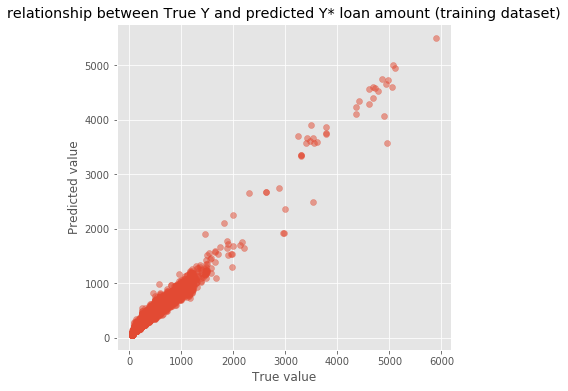

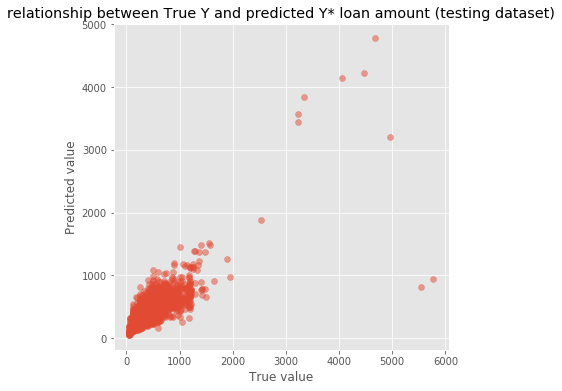

In [9]:
# plotting a graph of the true values vs the predicted values for the training and test datasets
def plot_y_yhat_scatter(y_actual,y_predicted,train_test):
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(y_actual, y_predicted, alpha=0.5)
    plt.xlabel('True value')
    plt.ylabel('Predicted value')
    plt.title("relationship between True Y and predicted Y* loan amount ({0} dataset)".format(train_test))
    plt.show()
    
plot_y_yhat_scatter(y_train, trained_regressor.predict(X_train),train_test = "training")
plot_y_yhat_scatter(y_test, trained_regressor.predict(X_test),train_test = "testing")


## 5. Tune Parameters
<a id='parameters'></a>

Again, how do we know the best combination of hyperparameters? 

**Cross validated Grid Search!**

We'll just search over a small range here to save time but usually we would search over a bigger range of hyperparameters. 

In [10]:
parameters = {'max_depth':[7,10,15], 
              'max_features': ['sqrt', 10, 15],
              'n_estimators': [300,400, 450]}
rf_regressor= RandomForestRegressor(n_jobs=-1, random_state=42)
regressor = GridSearchCV(rf_regressor, parameters)
regressor.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': ['sqrt', 10, 15], 'n_estimators': [300, 400, 450], 'max_depth': [7, 10, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [11]:
# print out what GridSearchCV found to be the best parameters 
regressor.best_estimator_.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 15,
 'max_features': 15,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 450,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [12]:
# get best parameters from grid search
parameters = regressor.best_estimator_.get_params()
# set the oob_score to True. This defaulted to False in the gridsearchCV to save time
parameters['oob_score'] = True
# train and evaluate our model
trained_regressor = train_score_regressor(sklearn_regressor = RandomForestRegressor,
                                          X_train = X_train, y_train = y_train, 
                                          X_test = X_test, y_test = y_test, 
                                          model_parameters = parameters,
                                          print_oob_score=True)


Train score: 0.892420160958
Test score: 0.628602835454
OOB score: 0.697596366117


The best R^2 achieved with the Decision Tree algorithm alone in Lab 4.1 gave us a train and test score of 0.69 and 0.57 respectively, whereas with the Random Forest Algorithm, they have increased to 0.89 and 0.63 respectively. 

**We have see that there has been a vast improvement using the Random Forest over the Decision Tree algorithm!**

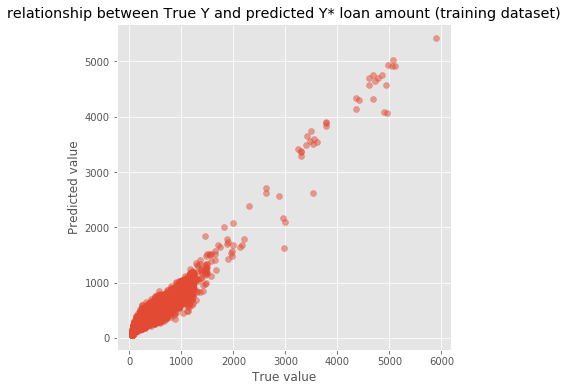

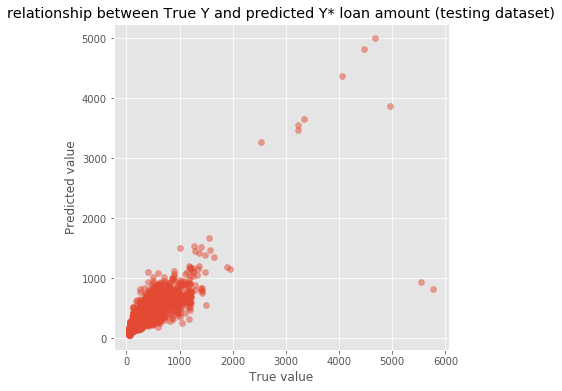

In [13]:
plot_y_yhat_scatter(y_train, trained_regressor.predict(X_train),train_test = "training")
plot_y_yhat_scatter(y_test, trained_regressor.predict(X_test),train_test = "testing")

## 6. Feature Importance
<a id='featureimportance'></a>

We can look at which features are driving our model's predictions by examining the feature importance. 

Remember the important but counter-intuitive thing to note here is that the magnitude of the 'importance' is not indicative of how important the feature is, only the order matters!

For example,
- feature A has an importance of 0.5 
- feature B has an importance of 0.25. 

Then all we can take away is that feature A is more explains more variance then feautre B, **not** that feature A explains twice as much as feature B. 

In [14]:
# Get the feature importances from our final trained model...
importances = trained_regressor.feature_importances_

# Find the indices of the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the important features in descending order
print('Feature Ranking:')
for f in range(len(importances)):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

Feature Ranking:
1. feature bc_partner_OAF_high (0.266431)
2. feature partner_dollar_amount (0.124809)
3. feature terms.repayment_term (0.119831)
4. feature days_to_fund (0.099371)
5. feature posted_month (0.047271)
6. feature hours_to_fund (0.037929)
7. feature age_int (0.035423)
8. feature posted_year (0.033082)
9. feature partner_delinquency_rate (0.031849)
10. feature num_partner_countries (0.023086)
11. feature bc_partner_OAF_low (0.021833)
12. feature top_partner_id (0.020694)
13. feature children_int (0.020676)
14. feature more_one_partner_country (0.017628)
15. feature num_tags (0.014239)
16. feature exploratory_partner (0.013732)
17. feature bc_partner_HIHEA (0.013334)
18. feature pct_female (0.010313)
19. feature sector_Agriculture (0.009091)
20. feature married (0.006125)
21. feature tag_#Repeat Borrower (0.006061)
22. feature bc_partner_others (0.005414)
23. feature tag_#Schooling (0.004242)
24. feature female (0.004134)
25. feature sector_Personal Use (0.003171)
26. featur

Again, what is interesting here is that there is not a very clear relationship between any single feature and the loan_amount. The most important feature borrower count for One Acre Fund during their high loan period - this is very specific to just a small subset of the data. 

However the aggregate of these features together into the decision leads to effective predictions (R^2 ~ 0.63). This is a testament to the predictive power of Random Forests!

## 7. Homework
<a id='homework'></a>

### Predicting Days to Fund
- Repeat the DecisionTreeRegressor method with a new target feature: days_to_fund.
- Use GridSearch to tune the parameters. 
- Determine the most important features and discuss which features are intuitive or a surprise and why. 

In [17]:
y = df['days_to_fund']
# drop returns a copy of the DataFrame with the specified columns removed.  
X = cols.drop('days_to_fund', axis=1)

In [18]:
# Create X_train, y_train, X_test and y_test where the y value is the days_to_fund feature. 
# Try using test_train_split function imported from sklearn

Remember the three basic steps:
- step 1: Initiate the algorithm
- step 2: Fit the algorithm to the training data
- step 3: Evaluate the algorithm performance

In [20]:
# Use the DecisionTreeRegressor method to predict the days_to_fund
# GridSearchCV to tune parameters
# Use the model attribute important_features_ to examine the feature importance. 